Previous notebooks

In [3]:
%run reference_circuit.ipynb

/tmp/ipykernel_20808/854499027.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  runtime_service_Jiri = QiskitRuntimeService(


Libraries

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

Configuration

In [5]:
NUM_QUBITS = 3
POP_SIZE = 10
N_GEN = 50
MUTATION_RATE = 0.5
ELITE_SIZE = 2
LAMBDA_DEPTH = 0.1

# Target distribution
x = np.arange(2**NUM_QUBITS)
p_target = np.exp(-0.5 * ((x - 3.5) / 1.0)**2)
p_target /= np.sum(p_target)
psi_target = np.sqrt(p_target)

Helper functions

In [38]:
def kl_divergence(p, q, eps=1e-10):
    p = np.clip(p, eps, 1)
    q = np.clip(q, eps, 1)
    return np.sum(p * np.log(p / q))

GATES = ['h', 'x', 'y', 'z', 'rx', 'ry', 'rz', 'cx', 'cz', 'sx']

def random_gate():
    g = random.choice(GATES)
    if g in ['rx', 'ry', 'rz']:
        return (g, random.randint(0, NUM_QUBITS - 1), random.uniform(0, 2*np.pi))
    elif g in ['cx', 'cz']:
        control = random.randint(0, NUM_QUBITS - 1)
        target = (control + 1) % NUM_QUBITS
        return (g, control, target)
    else:
        return (g, random.randint(0, NUM_QUBITS - 1))

def build_circuit(gates):
    qc = QuantumCircuit(NUM_QUBITS)
    for gate in gates:
        if gate[0] in ['rx', 'ry', 'rz']:
            print(gate)
            getattr(qc, gate[0])(gate[2], gate[1])
        elif gate[0] == 'cx':
            qc.cx(gate[1], gate[2])
        elif gate[0] == 'cz':
            qc.cz(gate[1], gate[2])
        else:
            getattr(qc, gate[0])(gate[1])
    return qc

def fitness(ind):
    qc = build_circuit(ind)
    state = Statevector.from_instruction(qc)
    probs = np.abs(state.data)**2
    kl = kl_divergence(p_target, probs)
    penalty = LAMBDA_DEPTH * qc.depth()
    return -(kl + penalty)  # maximize negative loss

# GA functions
def mutate(ind):
    ind = ind.copy()
    if random.random() < 0.5 and len(ind) > 1:
        ind[random.randint(0, len(ind)-1)] = random_gate()
    else:
        ind.append(random_gate())
    return ind

def crossover(p1, p2):
    if len(p1) < 2 or len(p2) < 2:
        return p1
    point = random.randint(1, min(len(p1), len(p2)) - 1)
    return p1[:point] + p2[point:]
    
def softmax(x, temperature=0.5): # higher temperature makes the distribution more flat (more uniform selection)
    # recomended temperature [0.1, 0.8]
    x = np.array(x)
    x = x - np.max(x)  # For numerical stability
    exps = np.exp(x / temperature)
    return exps / np.sum(exps)

def select(pop, fitnesses, temperature=0.5):
    probs = softmax(fitnesses, temperature)
    selected = random.choices(pop, weights=probs, k=POP_SIZE - ELITE_SIZE)
    # Keep elites deterministically
    elite_indices = np.argsort(fitnesses)[-ELITE_SIZE:]
    elites = [pop[i] for i in elite_indices]
    return elites + selected

def random_individual(length=10):
    return [random_gate() for _ in range(length)]

GA loop

In [40]:
adam = []
print(adam)
#print(population)

GHZ = np.array([1, 0, 0, 0, 0, 0, 0, 1]) / np.sqrt(2)
GHZ_evolve_matrix = householder_unitary(GHZ)
qc_ghz = create_reference_circuit(GHZ_evolve_matrix)

#print(build_circuit(GATES))
#print(qc_ghz)

indicies_used = set()
for gate in qc_ghz.data:
    #print(gate)
    adam.append([gate[0].name, gate[1][0]._index, gate[1][1]._index if len(gate[1]) > 1 else None])
    indicies_used.add(gate[1][0]._index)
    if adam[-1][-1] is None:
        adam[-1].pop()
    if gate[0].params:
        adam[-1] += gate[0].params
    if len(gate[1]) > 1:
        indicies_used.add(gate[1][1]._index)  

     
print(adam)
mapped_index = sorted(list(indicies_used))
print(mapped_index)
assert NUM_QUBITS == len(indicies_used)

for i in range(len(adam)):
    adam[i][1] = mapped_index.index(adam[i][1])
    if len(adam[i]) > 2 and adam[i][2] in indicies_used:
        adam[i][2] = mapped_index.index(adam[i][2])

print(adam)
population = [adam]

# generate elites as adam mutations
while len(population) < ELITE_SIZE:
    population.append(mutate(adam))

# generate rest random
while len(population) < POP_SIZE:
    population.append(random_individual())


[]
Circuit depth: 123
[['sx', 88], ['rz', 89, 0.4252265201142027], ['sx', 89], ['rz', 89, -1.5707963267948957], ['rz', 90, 1.145569806680692], ['sx', 90], ['rz', 90, -1.5707963267948966], ['cz', 89, 90], ['sx', 89], ['rz', 89, 0.7853981633974492], ['sx', 89], ['sx', 90], ['rz', 90, -0.7853981633974483], ['cz', 89, 90], ['rz', 89, -3.1415926535897913], ['sx', 89], ['rz', 89, 2.7814210103065493], ['sx', 89], ['cz', 88, 89], ['sx', 88], ['sx', 89], ['cz', 88, 89], ['sx', 88], ['sx', 89], ['cz', 88, 89], ['rz', 89, 1.5707963267948966], ['sx', 89], ['sx', 90], ['rz', 90, 0.7203432865664858], ['cz', 90, 89], ['sx', 89], ['rz', 89, -2.356194490192344], ['sx', 89], ['rz', 89, -3.1415926535897936], ['cz', 88, 89], ['x', 88], ['sx', 89], ['rz', 89, -2.356194490192344], ['sx', 89], ['rz', 89, -4.71238898038469], ['cz', 90, 89], ['cz', 88, 89], ['x', 88], ['rz', 88, -1.5707963267948983], ['sx', 89], ['rz', 89, -0.3926990816987246], ['sx', 90], ['cz', 90, 89], ['sx', 89], ['sx', 90], ['cz', 90, 89]

/tmp/ipykernel_20808/2125994679.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  adam.append([gate[0].name, gate[1][0]._index, gate[1][1]._index if len(gate[1]) > 1 else None])
/tmp/ipykernel_20808/2125994679.py:16: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  indicies_used.add(gate[1][0]._index)
/tmp/ipykernel_20808/2125994679.py:19: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  if gate[0].params:
/tmp/ipykernel_20808/2125994679.py:21: DeprecationWarning: Treating CircuitIn

[['sx', 0], ['rz', 1, 0.4252265201142027], ['sx', 1], ['rz', 1, -1.5707963267948957], ['rz', 2, 1.145569806680692], ['sx', 2], ['rz', 2, -1.5707963267948966], ['cz', 1, 2], ['sx', 1], ['rz', 1, 0.7853981633974492], ['sx', 1], ['sx', 2], ['rz', 2, -0.7853981633974483], ['cz', 1, 2], ['rz', 1, -3.1415926535897913], ['sx', 1], ['rz', 1, 2.7814210103065493], ['sx', 1], ['cz', 0, 1], ['sx', 0], ['sx', 1], ['cz', 0, 1], ['sx', 0], ['sx', 1], ['cz', 0, 1], ['rz', 1, 1.5707963267948966], ['sx', 1], ['sx', 2], ['rz', 2, 0.7203432865664858], ['cz', 2, 1], ['sx', 1], ['rz', 1, -2.356194490192344], ['sx', 1], ['rz', 1, -3.1415926535897936], ['cz', 0, 1], ['x', 0], ['sx', 1], ['rz', 1, -2.356194490192344], ['sx', 1], ['rz', 1, -4.71238898038469], ['cz', 2, 1], ['cz', 0, 1], ['x', 0], ['rz', 0, -1.5707963267948983], ['sx', 1], ['rz', 1, -0.3926990816987246], ['sx', 2], ['cz', 2, 1], ['sx', 1], ['sx', 2], ['cz', 2, 1], ['sx', 1], ['sx', 2], ['cz', 2, 1], ['rz', 1, 0.9882507899685269], ['sx', 1], ['rz

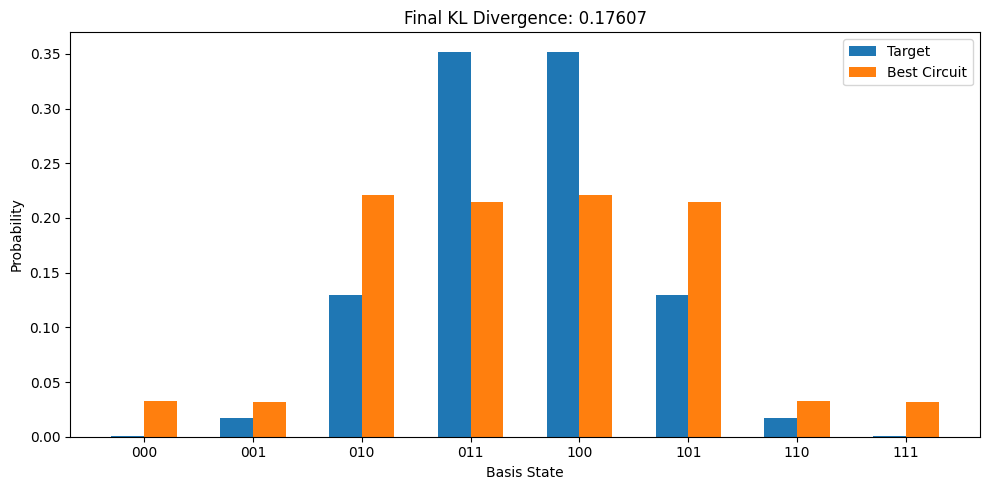

Best circuit:
         ┌────────────┐┌───┐┌────────────┐                   
q_0: ─■─┤ Ry(1.5865) ├┤ Y ├┤ Rx(5.8539) ├──────■────────────
      │ └───┬───┬────┘├───┤└────────────┘      │            
q_1: ─┼─────┤ Z ├─────┤ H ├──────■─────────────■────────────
      │     ├───┤     └───┘      │       ┌────────────┐┌───┐
q_2: ─■─────┤ H ├────────────────■───────┤ Ry(3.8759) ├┤ H ├
            └───┘                        └────────────┘└───┘


In [41]:
#population = [random_individual() for _ in range(POP_SIZE)]
best_fitness = -np.inf
best_individual = None

for gen in range(N_GEN):
    for ind in population:
        print(ind)
    fitnesses = [fitness(ind) for ind in population]
    max_fit = max(fitnesses)
    print(f"Gen {gen}, best fitness: {-max_fit:.4f}")
    if max_fit > best_fitness:
        best_fitness = max_fit
        best_individual = population[np.argmax(fitnesses)]
    selected = select(population, fitnesses)
    new_pop = selected[:ELITE_SIZE]
    while len(new_pop) < POP_SIZE:
        p1, p2 = random.sample(selected, 2)
        child = crossover(p1, p2)
        if random.random() < MUTATION_RATE:
            child = mutate(child)
        new_pop.append(child)
    population = new_pop

# Evaluate best individual
qc_best = build_circuit(best_individual)
print(qc_best.draw(output='text'))
state_best = Statevector.from_instruction(qc_best)
probs_best = np.abs(state_best.data) ** 2
kl_best = kl_divergence(p_target, probs_best)

# Plot
labels = [f'{i:03b}' for i in range(len(p_target))]
x = np.arange(len(p_target))

plt.figure(figsize=(10, 5))
plt.bar(x - 0.15, p_target, width=0.3, label='Target', align='center')
plt.bar(x + 0.15, probs_best, width=0.3, label='Best Circuit', align='center')
plt.xticks(x, labels)
plt.xlabel('Basis State')
plt.ylabel('Probability')
plt.title(f'Final KL Divergence: {kl_best:.5f}')
plt.legend()
plt.tight_layout()
plt.show()

print("Best circuit:\n", qc_best.draw())
